# **EDA For Reviews**

-----
### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandasql import sqldf

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

------
## Read in the Data

In [2]:
reviews = pd.read_csv('../data/reviews_cleaned.csv', low_memory=False)
reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
0,3781,37776825,2015-07-10,36059247.0,Greg,The apartment was as advertised and Frank was ...,the apartment was as advertised and frank was ...
1,3781,41842494,2015-08-09,10459388.0,Tai,It was a pleasure to stay at Frank's place. Th...,it was a pleasure to stay at frank's place. th...
2,3781,45282151,2015-09-01,12264652.0,Damien,The apartment description is entirely faithful...,the apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327.0,Mike,Thoroughly enjoyed my time at Frank's home. Ha...,thoroughly enjoyed my time at frank's home. ha...
4,3781,52503327,2015-10-30,15151513.0,Ivan,Great value for the money! This location has e...,great value for the money! this location has e...


In [3]:
reviews.dtypes

listing_id         object
review_id          object
date               object
reviewer_id       float64
reviewer_name      object
comments           object
lower_comments     object
dtype: object

In [4]:
# ensuring date column is correct data type (wasn't retained when csv read in)
pd.to_datetime(reviews['date'], errors = 'coerce')

0        2015-07-10
1        2015-08-09
2        2015-09-01
3        2015-09-30
4        2015-10-30
            ...    
232213   2022-05-12
232214   2022-05-22
232215   2022-05-29
232216   2022-06-08
232217   2022-06-10
Name: date, Length: 232218, dtype: datetime64[ns]

In [5]:
reviews.dtypes

listing_id         object
review_id          object
date               object
reviewer_id       float64
reviewer_name      object
comments           object
lower_comments     object
dtype: object

In [6]:
reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
0,3781,37776825,2015-07-10,36059247.0,Greg,The apartment was as advertised and Frank was ...,the apartment was as advertised and frank was ...
1,3781,41842494,2015-08-09,10459388.0,Tai,It was a pleasure to stay at Frank's place. Th...,it was a pleasure to stay at frank's place. th...
2,3781,45282151,2015-09-01,12264652.0,Damien,The apartment description is entirely faithful...,the apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327.0,Mike,Thoroughly enjoyed my time at Frank's home. Ha...,thoroughly enjoyed my time at frank's home. ha...
4,3781,52503327,2015-10-30,15151513.0,Ivan,Great value for the money! This location has e...,great value for the money! this location has e...


-------
### **Exploring Reviews Data Frame**

In [7]:
sql = """
SELECT *
FROM reviews
LIMIT 5;
"""

df = sqldf(sql)
df.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
0,3781,37776825,2015-07-10,36059247.0,Greg,The apartment was as advertised and Frank was ...,the apartment was as advertised and frank was ...
1,3781,41842494,2015-08-09,10459388.0,Tai,It was a pleasure to stay at Frank's place. Th...,it was a pleasure to stay at frank's place. th...
2,3781,45282151,2015-09-01,12264652.0,Damien,The apartment description is entirely faithful...,the apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327.0,Mike,Thoroughly enjoyed my time at Frank's home. Ha...,thoroughly enjoyed my time at frank's home. ha...
4,3781,52503327,2015-10-30,15151513.0,Ivan,Great value for the money! This location has e...,great value for the money! this location has e...


----
### Reviews by Users and Listings

In [8]:
sql = """
SELECT COUNT(*) AS num_reviews
FROM reviews;
"""

df = sqldf(sql)
df.head()

,num_reviews
0,232218


In [9]:
sql = """
SELECT COUNT(DISTINCT review_id) AS num_distinct_reviews
FROM reviews;
"""

df = sqldf(sql)
df.head()

,num_distinct_reviews
0,229171


In [10]:
sql = """
SELECT COUNT(DISTINCT listing_id) AS num_distinct_listings
FROM reviews;
"""

df = sqldf(sql)
df.head()

,num_distinct_listings
0,6176


In [11]:
sql = """
SELECT COUNT(DISTINCT reviewer_id) AS num_reviewers
FROM reviews
LIMIT 5;
"""

df = sqldf(sql)
df.head()

,num_reviewers
0,208450


In [12]:
# users with most reviews
sql = """
SELECT reviewer_id, reviewer_name, COUNT(DISTINCT review_id) AS num_reviews
FROM reviews
GROUP BY reviewer_id
ORDER BY COUNT(review_id) DESC;
"""

df = sqldf(sql)
df.head(10)

,reviewer_id,reviewer_name,num_reviews
0,NaN,None,827
1,87095873.0,Thomas M,55
2,134772735.0,Aman,52
3,132765892.0,Arie,41
4,217937282.0,Jon,32
5,40651868.0,Harry,32
6,171180734.0,John,29
7,265228708.0,Matt,26
8,81255595.0,Susan,26
9,12096536.0,Marie,26


In [13]:
# listings with most reviews
sql = """
SELECT listing_id, COUNT(DISTINCT review_id) AS num_reviews
FROM reviews
GROUP BY listing_id
ORDER BY COUNT(review_id) DESC;
"""

df = sqldf(sql)
df.head(10)

,listing_id,num_reviews
0,682093,1071
1,2676488,990
2,46534,927
3,4090224,729
4,815639,708
5,916123,692
6,3510127,684
7,12318450,670
8,3506058,659
9,18290558,659


----
### Lengths of Reviews and Common Words

In [14]:
# create new columns for comment character length and word count
reviews['comment_char_length'] = [len(str(i)) for i in reviews['lower_comments']]
reviews['comment_word_count'] = [len(str(i).split(" ")) for i in reviews['lower_comments']]
reviews.head(3)

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments,comment_char_length,comment_word_count
0,3781,37776825,2015-07-10,36059247.0,Greg,The apartment was as advertised and Frank was ...,the apartment was as advertised and frank was ...,133,20
1,3781,41842494,2015-08-09,10459388.0,Tai,It was a pleasure to stay at Frank's place. Th...,it was a pleasure to stay at frank's place. th...,414,86
2,3781,45282151,2015-09-01,12264652.0,Damien,The apartment description is entirely faithful...,the apartment description is entirely faithful...,358,60


In [15]:
reviews[['comment_word_count', 'comment_char_length']].describe()

,comment_word_count,comment_char_length
count,232218.000000,232218.000000
mean,42.314390,238.190476
std,46.534495,256.387435
min,1.000000,1.000000
25%,13.000000,78.000000
50%,29.000000,168.000000
75%,56.000000,313.000000
max,1037.000000,5928.000000


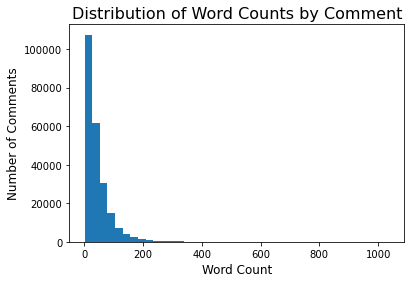

In [16]:
# Distribution of Word Counts
plt.hist(reviews['comment_word_count'], bins = 40)
plt.title('Distribution of Word Counts by Comment', fontsize =16)
plt.xlabel('Word Count', fontsize =12)
plt.ylabel('Number of Comments', fontsize =12);

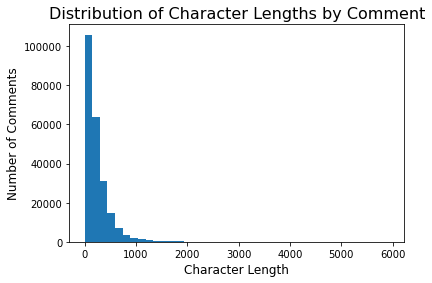

In [17]:
# Distribution of Character Lengths
plt.hist(reviews['comment_char_length'], bins = 40)

plt.title('Distribution of Character Lengths by Comment', fontsize =16)
plt.xlabel('Character Length', fontsize =12)
plt.ylabel('Number of Comments', fontsize =12);

In [18]:
# looking at longest and shortest posts by character length
print(reviews[['listing_id','reviewer_name','comment_char_length']].sort_values('comment_char_length', ascending=False).head(5))
print(" ")
print("*"*60)
print(" ")
print(reviews[['listing_id','reviewer_name','comment_char_length']].sort_values('comment_char_length').head(5))

       listing_id reviewer_name  comment_char_length
73843     9685076        Kelton                 5928
177885   29816287         Karen                 5639
158655   24378766          Dave                 5596
222200   50084140         Alina                 5585
221485   49754318         Autum                 5558
 
************************************************************
 
       listing_id reviewer_name  comment_char_length
41773     4112094           Ram                    1
178112   30539659          Cory                    1
82815    11732852           Ana                    1
194438   38018931            정운                    1
141885   20661430          Gabe                    1


In [19]:
# looking at longest and shortest posts by word count
print(reviews[['listing_id','reviewer_name','comment_word_count']].sort_values('comment_word_count', ascending=False).head(5))
print(" ")
print("*"*60)
print(" ")
print(reviews[['listing_id','reviewer_name','comment_word_count']].sort_values('comment_word_count').head(5))

       listing_id reviewer_name  comment_word_count
158655   24378766          Dave                1037
177885   29816287         Karen                1035
141327   20633588         Dolly                1029
221485   49754318         Autum                1003
188360   33789540          Lisa                 989
 
************************************************************
 
       listing_id reviewer_name  comment_word_count
164465   24888817       Michele                   1
127396   18194673        Sayuri                   1
214319   48103324        Joshua                   1
62794     7330494      Seongjin                   1
176091   29390698         Paula                   1


---

## **EDA Specifically on Comments Column**

#### Vectorize the text to look at Common Word Appearances

-----
### *CountVectorize*

In [20]:
reviews.shape

(232218, 9)

In [22]:
# Instantiate the CountVectorizer and transform 
cvec = CountVectorizer(max_features=50)
post_matrix = cvec.fit_transform(reviews['lower_comments'].astype('U').values)

# Creating dataframe of text data
post_df = pd.DataFrame(post_matrix.todense(),
                      columns = cvec.get_feature_names_out())
post_df.shape

(232218, 50)

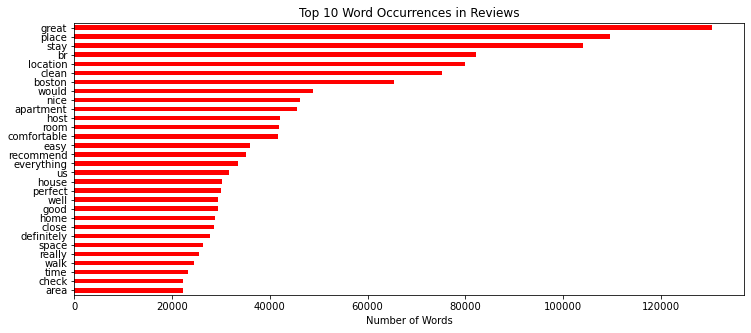

In [43]:
# check to see the top words - if mostly stopwords, get rid of stopwords
# code taken from lesson 5.05 on Natural Language Processing

post_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'r')
plt.gca().invert_yaxis() # this code was taken from Andras Deak's response on stack overflow
# https://stackoverflow.com/questions/34076177/matplotlib-horizontal-bar-chart-barh-is-upside-down
plt.title('Top 20 Word Occurrences in Reviews')
plt.xlabel('Number of Words');

In [44]:
stopword_list = stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

(232218, 50)


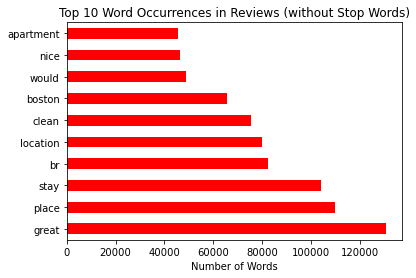

In [45]:
# most are stop words - recreate dataframe without stopwords
cvec = CountVectorizer(max_features=50, stop_words=stopword_list)
post_matrix = cvec.fit_transform(reviews['lower_comments'].astype('U').values)

# new dataframe
post_df = pd.DataFrame(post_matrix.todense(), columns = cvec.get_feature_names_out())
print(post_df.shape)
plt.gca().invert_yaxis()
post_df.sum().sort_values(ascending=False).head(20).plot(kind = 'barh', color='r')
plt.title('Top 20 Word Occurrences in Reviews (without Stop Words)')
plt.xlabel('Number of Words');

In [46]:
# Instantiate the CountVectorizer and transform 
# changed the number of max features
cvec = CountVectorizer(max_features=100)
post_matrix = cvec.fit_transform(reviews['lower_comments'].astype('U').values)

# Creating dataframe of text data
post_df = pd.DataFrame(post_matrix.todense(),
                      columns = cvec.get_feature_names_out())
post_df.shape

(232218, 100)

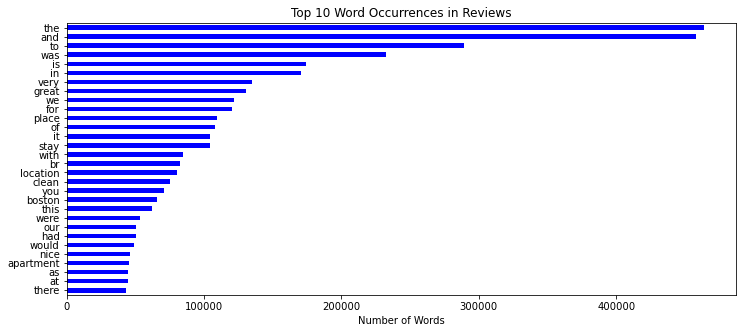

In [47]:
# check to see the top words - if mostly stopwords, get rid of stopwords
# code taken from lesson 5.05 on Natural Language Processing

post_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'b')
plt.gca().invert_yaxis()
plt.title('Top 20 Word Occurrences in Reviews')
plt.xlabel('Number of Words');

(232218, 100)


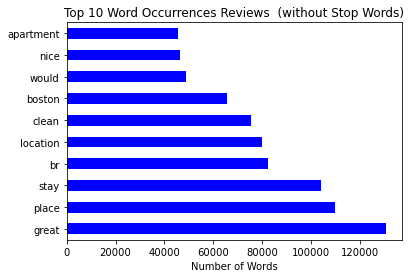

In [48]:
# most are stop words - recreate dataframe without stopwords
cvec = CountVectorizer(max_features=100, stop_words=stopword_list)
post_matrix = cvec.fit_transform(reviews['lower_comments'].astype('U').values)

# new dataframe
post_df = pd.DataFrame(post_matrix.todense(), columns = cvec.get_feature_names_out())
print(post_df.shape)
plt.gca().invert_yaxis()
post_df.sum().sort_values(ascending=False).head(20).plot(kind = 'barh', color='b')
plt.title('Top 20 Word Occurrences in Reviews (without Stop Words)')
plt.xlabel('Number of Words');

-----
### *(TF-IDF) Vectorizer*

In [49]:
# Instantiate the Tfidf Vectorizer and transform 
tvec = TfidfVectorizer(max_features = 50)
post_matrix = tvec.fit_transform(reviews['lower_comments'].astype('U').values)

# Creating dataframe of text data
post_df = pd.DataFrame(post_matrix.todense(),
                      columns = tvec.get_feature_names_out())
post_df.shape

(232218, 50)

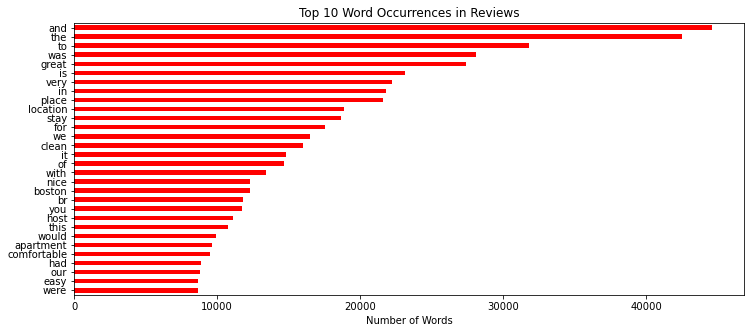

In [50]:
# check to see the top words - if mostly stopwords, get rid of stopwords

post_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'r')
plt.gca().invert_yaxis()
plt.title('Top 20 Word Occurrences in Reviews')
plt.xlabel('Number of Words');

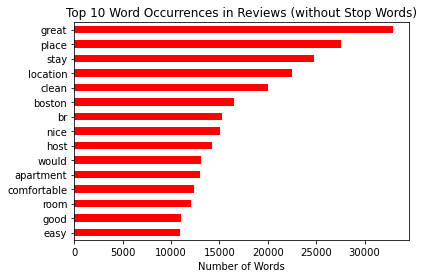

In [52]:
# most are stop words - recreate dataframe without stopwords
tvec = TfidfVectorizer(max_features = 50, stop_words=stopword_list)
post_matrix = tvec.fit_transform(reviews['lower_comments'].astype('U').values)

# new dataframe
post_df = pd.DataFrame(post_matrix.todense(), columns = tvec.get_feature_names_out())
post_df.shape

post_df.sum().sort_values(ascending=False).head(20).plot(kind = 'barh', color='r')
plt.gca().invert_yaxis()
plt.title('Top 20 Word Occurrences in Reviews (without Stop Words)')
plt.xlabel('Number of Words');

In [54]:
# may be important to adjust stop words parameter when modeling